In [173]:
'''
plot properties of SP (binned to time-height space) and output of PAMTRA
'''
#import modulus
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import re

In [174]:
#specifiy experiment
directory = "/home/mkarrer/Dokumente/McSnow/MCSNOW/experiments/"
experiment="1d_xi100000_nz5000_lwc20_ncl0_dtc5_nrp30_rm10_rt2_vt2_h10-20_ba500"
filestring = directory + experiment + '/mass2fr.dat'
#load file from .dat TODO: load from NetCDF
allSPalltimesteps = np.loadtxt(filestring)

In [175]:
#TODO: select timesteps
allSP = allSPalltimesteps
#read individual properties of the SPs
sp_m_tot = allSP[:,0] #read mass of all particles
sp_Frim = allSP[:,1]   #SP rime fraction
sp_height = allSP[:,2] #SP height
sp_vt = allSP[:,4]     #SPfall speed
sp_multipl = allSP[:,5] #SP multiplicity
sp_rhorime = allSP[:,6] #SP rime density
sp_diam = allSP[:,9]    #SP diameter
sp_projA = allSP[:,10]  #SP projected area
sp_monomer = allSP[:,11] #SP number of monomer

In [176]:
'''
seperate by height and diameter bin
'''
#define hydrometeor properties
n_bins = 100 #bins for PAMTRA calculation
n_heights = 51 #heights for PAMTRA calculation
#create height vector
model_top = 5000. #top of model / m
z_res = model_top/n_heights #vertical resolution
heightvec = np.linspace(0,model_top,n_heights) #start with 0+z_res and go n_heigts step up to model_top
#define arrays with sp_diam
d_bound_ds = np.logspace(-9,0,n_bins+1) #array from 1nm to 1m
d_ds = d_bound_ds[:-1] + 0.5*np.diff(d_bound_ds) #diameter at center of bins
d_counts = np.zeros([n_heights,n_bins]) #number of RP at each h-D bin
d_counts_no_mult = np.zeros([n_heights,n_bins]) #number of SP at each h-D bin
av_Frim = np.zeros([n_heights,n_bins]) #mass averaged rime fraction for each h-D bin
av_rhorime = np.zeros([n_heights,n_bins]) #mass averaged rime density for each h-D bin
av_Nmon = np.zeros([n_heights,n_bins]) #multiplicity weighted number
#get the number of particles (SP*sp_multiplicity) at each bin (binned by height and sp_diameter)
for i in range(0,n_heights-1):
    for j in range(0,n_bins):
                condition_in_bin = np.logical_and(
                                np.logical_and(d_bound_ds[j]<=sp_diam,sp_diam<d_bound_ds[j+1]),
                                np.logical_and(heightvec[i]<=sp_height,sp_height<heightvec[i+1]),
                                )
                d_counts[i,j] = np.sum(np.where(condition_in_bin,sp_multipl,0))
                d_counts_no_mult[i,j] = np.sum(np.where(condition_in_bin,1,0))
                #get total number of RP per bin
                multipl_bin = np.sum(np.where(condition_in_bin,sp_multipl,0))            
                #get sum of qirim per bin
                qirim_bin = np.sum(np.where(condition_in_bin,sp_m_tot*sp_Frim*sp_multipl,0))SP[""]
                #get sum of qitot
                qitot_bin = np.sum(np.where(condition_in_bin,sp_m_tot*sp_multipl,0))
                av_Frim[i,j] = qirim_bin/qitot_bin #calc. mass averaged rime fraction
                #calc. rime mass averaged rime density
                av_rhorime[i,j] = np.sum(np.where(condition_in_bin,sp_m_tot*sp_Frim*sp_multipl*sp_rhorime,0))/qitot_bin
                #calc. multipl averaged
                av_Nmon[i,j] = np.sum(np.where(condition_in_bin,sp_monomer*sp_multipl,0))/multipl_bin

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


In [178]:
#read box area from string
zres = heightvec[1]-heightvec[0]
box_area = float(re.search('ba(.*)/mass2fr', filestring).group(1)) *1./100. #this line gets the values after ba and before /mass2fr ; 1/100m^2 is the specification of the unit in the McSnow runscripts
V=box_area*zres
#convert number per height bin [#] to numper per volume [#/m3]
d_counts = d_counts/box_area/z_res
d_counts_no_mult = d_counts_no_mult/box_area/z_res

In [179]:
def pcol_height_diam(diam,heights,var,mincol=-999,maxcol=-999,grid=(1,1),pos=(0,0),cmap='viridis_r',collabel='',ticks=np.array([-999])):
    ax = plt.subplot2grid(grid, pos)
    
    if mincol==-999: #set range of colorbar automatically
        pcol = ax.pcolormesh(diam,heights,var,rasterized=True,cmap=cmap) #norm=norm)
    else: #set range of colorbar via mincol, maxcol
        pcol = ax.pcolormesh(diam,heights,var,rasterized=True,cmap=cmap,vmin=mincol,vmax=maxcol) #,norm=norm)
        
    #modify axis
    ax.set_xscale("log")
    #TODO: give this as an input
    ax.set_xlim([10**-5,10**-2])
    #plot colorbar
    if ticks[0]==-999: #automatic ticks
        col = plt.colorbar(pcol)
    else:#predefined ticks
        col = plt.colorbar(pcol,ticks=ticks)

    col.set_label(collabel, rotation=90)
    #set labels
    ax.set_xlabel('diameter / m ')
    ax.set_ylabel('height / m ')
    return ax,col

In [180]:
def colbar_lowest_white(cmap,lenbounds=100):
    #adds a white color for the lowest values to the predefined colorbar 
    exec("colors1=plt.cm." + cmap + "(np.linspace(0.0,1.0,lenbounds))")
    colors2=plt.cm.Greys(0)
    colors_merged=np.vstack((colors2,colors1))
    new_cmap = colors.ListedColormap([colors_merged[i] for i in range(0,lenbounds)])
    return new_cmap

50000.0 0 150000.0 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f7740411710>,
 <matplotlib.colorbar.Colorbar at 0x7f77403719d0>)

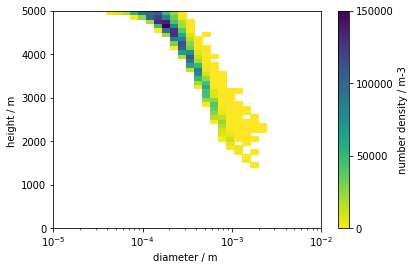

In [218]:
cmap="viridis_r"
ticksstep=50000.
mincol = 0;maxcol=math.ceil(np.max(d_counts) / ticksstep) * ticksstep #mincol must be a small value greater than 0 to distinguish 0 from a small value; maxcol is rounded to the next 10000 to have round values in the colorbar
ticks = np.arange(mincol, maxcol*1.0001, ticksstep)
d_counts_masked = np.ma.array(d_counts,mask=(d_counts==0))
print ticksstep,mincol,maxcol,d_counts_masked
pcol_height_diam(d_bound_ds,heightvec,d_counts_masked,mincol=mincol,maxcol=maxcol,cmap=cmap,collabel='number density / m-3',ticks=ticks) #,grid=(1,1),pos=(0,0),cmap=new_cmap)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


(<matplotlib.axes._subplots.AxesSubplot at 0x7f77379fb410>,
 <matplotlib.colorbar.Colorbar at 0x7f7737844350>)

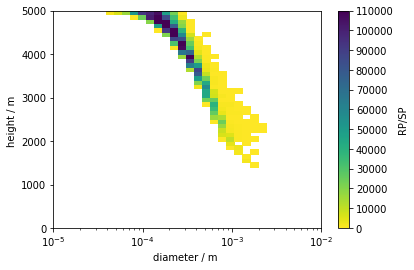

In [196]:
cmap="viridis_r"
ticksstep = 10000
RPdSP = d_counts/d_counts_no_mult #real particle divided by super particle
mincol = 0;maxcol=math.ceil(np.nanmax(d_counts/d_counts_no_mult) / ticksstep) * ticksstep #mincol must be a small value greater than 0 to distinguish 0 from a small value; maxcol is rounded to the next 10000 to have round values in the colorbar
ticks = np.arange(mincol, maxcol*1.0001, ticksstep)
#mask array
RPdSP_masked = np.ma.array(d_counts,mask=np.isnan(RPdSP))
pcol_height_diam(d_bound_ds,heightvec,RPdSP_masked,mincol=mincol,maxcol=maxcol,ticks=ticks,grid=(1,1),pos=(0,0),cmap=cmap,collabel='RP/SP')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f77371d0090>,
 <matplotlib.colorbar.Colorbar at 0x7f77376d6710>)

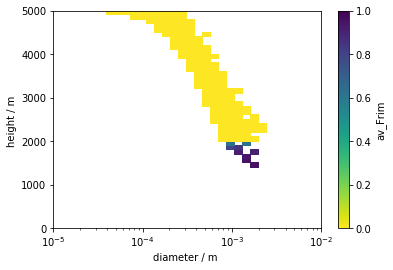

In [198]:
new_cmap="viridis_r"
ticksstep = 0.2
mincol = 0;maxcol=math.ceil(np.nanmax(av_Frim) / ticksstep) * ticksstep #mincol must be a small value greater than 0 to distinguish 0 from a small value; maxcol is rounded to the next 10000 to have round values in the colorbar
ticks = np.arange(mincol, maxcol*1.0001, ticksstep)
#mask array
av_Frim_masked = np.ma.array(av_Frim,mask=np.isnan(av_Frim))
pcol_height_diam(d_bound_ds,heightvec,av_Frim,grid=(1,1),pos=(0,0),cmap=new_cmap,collabel='av_Frim',mincol=0,maxcol=1)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f77371d0a10>,
 <matplotlib.colorbar.Colorbar at 0x7f7737539250>)

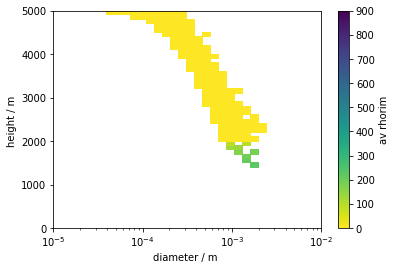

In [199]:
new_cmap="viridis_r"
ticksstep = 100
mincol = 0;maxcol=math.ceil(np.nanmax(av_rhorime) / ticksstep) * ticksstep #mincol must be a small value greater than 0 to distinguish 0 from a small value; maxcol is rounded to the next 10000 to have round values in the colorbar
ticks = np.arange(mincol, maxcol*1.0001, ticksstep)
#mask array
av_rhorime_masked = np.ma.array(av_rhorime,mask=np.isnan(av_rhorime))
pcol_height_diam(d_bound_ds,heightvec,av_rhorime_masked,grid=(1,1),pos=(0,0),cmap=new_cmap,collabel='av rhorim',mincol=0,maxcol=900)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7736658050>,
 <matplotlib.colorbar.Colorbar at 0x7f7736448cd0>)

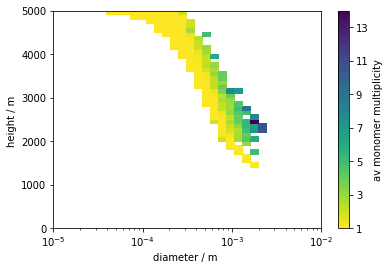

In [211]:
new_cmap="viridis_r"
ticksstep = 2
mincol = 1;maxcol=math.ceil(np.nanmax(av_Nmon) / ticksstep) * ticksstep #mincol must be a small value greater than 0 to distinguish 0 from a small value; maxcol is rounded to the next 10000 to have round values in the colorbar
ticks = np.arange(mincol, maxcol*1.0001, ticksstep)
#mask array
av_Nmon_masked = np.ma.array(av_Nmon,mask=np.isnan(av_Nmon))
pcol_height_diam(d_bound_ds,heightvec,av_Nmon,mincol=mincol,maxcol=maxcol,ticks=ticks,grid=(1,1),pos=(0,0),cmap=new_cmap,collabel='av monomer multiplicity')

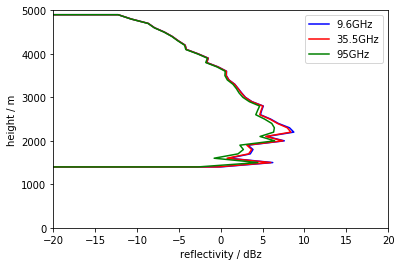

In [214]:
'''
read and plot pamtra output
'''
#import modules
from netCDF4 import Dataset #for reading NetCDF

#define file to read
pam_filestring = directory + experiment + '/pamtra_output.nc'
#load file
pam_file = Dataset(pam_filestring,mode='r')
#create dictionary for all variables from PAMTRA
pamData = dict()
#print pam_file.variables.keys() 

#if necessary change name of variables
varlistin = pam_file.variables
varlistout = pam_file.variables
#read PAMTRA variables to pamData dictionary
for varin,varout in zip(varlistin,varlistout):#read files and write it with different names in Data
    pamData[varout] = np.squeeze(pam_file.variables[varin])

    #create figure for plotting of pamtra output
fig = plt.figure()
ax1 = fig.add_subplot(111)

#plot X-,Ka-,W-Band in three different colors
ax1.plot(pamData["Ze"][:,0],pamData["height"], 'b-')
ax1.plot(pamData["Ze"][:,1],pamData["height"], 'r-')
ax1.plot(pamData["Ze"][:,2],pamData["height"], 'g-')

#set range
ax1.set_xlim([-20,20]) #range of Ze
#TODO: set height flexible
ax1.set_ylim([0,5000])
ax1.set_xlabel("reflectivity / dBz")
ax1.set_ylabel("height / m")
ax1.legend(["9.6GHz","35.5GHz","95GHz"])

In [215]:
!jupyter nbconvert --to script McSnow_PAMTRA_subplots.ipynb

[NbConvertApp] Converting notebook McSnow_PAMTRA_subplots.ipynb to script
[NbConvertApp] Writing 9664 bytes to McSnow_PAMTRA_subplots.py
